# Projeto 4 - Recomendação de vinhos - Wine Reviews

## Wine Reviews - Kaggle
O conjunto de dados Wine Reviews possui o comentário e a nota dada por cada especialista sobre diversos vinhos. O autor se inspirou para fazer este conjunto de dados após assistir Somm, um documentário sobre mestres sommeliers de vinho.

# Preparação do ambiente
- Para este projeto, acessem o link do Kaggle (https://www.kaggle.com/datasets/zynicide/wine-reviews).
- Crie o projeto no Github
- Use o cookiecutter para organizar o projeto
- Leia todo o material disponibilizado no Kaggle para entender esses dados
- Caso precise, leia outros projetos que usaram este mesmo conjunto de dados

In [1]:
!git clone https://github.com/aaasatoou/BlueEdTech_M4.git
!pip install -U pandas-profiling
!pip install markupsafe==2.0.1
!python -m spacy download en_core_web_lg

Cloning into 'BlueEdTech_M4'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 10 (delta 0), reused 3 (delta 0), pack-reused 7
Unpacking objects: 100% (10/10), done.
Checking out files: 100% (4/4), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 5.0 MB/s 
     |████████████████████████████████| 4.7 MB 34.0 MB/s 
     |████████████████████████████████| 596 kB 42.2 MB/s 
     |████████████████████████████████| 102 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 690 kB 43.9 MB/s 
     |████████████████████████████████| 812 kB 46.6 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=bef00c466a03d2883ff257b5b8bc2809bdbb09cc1c0f7f0e6d386618b4741952
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201

# Exercícios
Separe o notebook entre analise exploratória, construção do sistema de recomendação e relatório.


## (3 pontos) Análise exploratória: 
Realize as análises deste conjunto de dados, crie gráficos e anote as suas idéias.

### Entendimento do negócio


Dicionário:
- country: The country that the wine is from.
- description: Decription made by a sommelier.
- designation: The vineyard within the winery where the grapes that made the wine are from.
- points: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- price: The cost for a bottle of the wine.
- province: The province or state that the wine is from.
- region_1: The wine growing area in a province or state (ie Napa).
- region_2: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.
- taster_name: taster name.
- taster_twitter_handle: taster twitter handle ('@taster' for example).
- title: The title of the wine review, which often contains the vintage if you're interested in extracting that feature.
- variety: The type of grapes used to make the wine (ie Pinot Noir).
- winery: The winery that made the wine.

O conjunto de dados possui comentário e notas dadas por especialistas sobre diversos vinhos. A ideia é criar um sistema de recomendação baseado em conteúdo, ou seja, utilizar os feedbacks do próprio usuário como base para o aprendizado e recomendação de outros vinhos.

### Entendimento dos dados

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

wine_rev = pd.read_csv('/content/BlueEdTech_M4/Datasets/Wine Reviews/winemag-data-130k-v2.csv', index_col='Unnamed: 0')
wine_rev.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
from pandas_profiling import ProfileReport

ProfileReport(wine_rev)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Com as estatísticas iniciais do profilling report já podemos tomar as primeiras iniciativas em relação ao pré-processamento do conjunto de dados. Primeiro, sabemos que teremos que lidar com valores nulos durante o processo de recomendação. Segundo, há 1894 linhas duplicadas e tratando-se de processos de recomendação, essas linhas podem gerar problemas no futuro.

A variável 'country' possui valores faltantes e alta correlação em relação as variáveis 'taster_name', 'taster_twitter_handle' e 'region_2'. Isso acontece por uma questão de causalidade como a variável 'country' trata do país de origem do vinho, espera-se que seja de alguma região que produza vinhos. Também se espera que, em grande parte, os degustadores sejam daquele país.

A variável 'description' não possui valores faltantes e possui valores distintos, é uma boa variável para se usar para a recomendação.

A variável 'designation' é o vinhedo de onde vem as uvas que compõe o vinho, possui muitos valores faltantes.

A variável 'points' não possui valores faltantes, possui mínimo 80 e máximo 100. É uma boa variável para se usar para a recomendação.

A variável 'price' possui valores faltantes, mínimo 4 e máximo 3300, aparenta possuir muitos outliers, porém, outliers naturais, será analisada mais profundamente.

A variável 'province' possui alguns valores faltantes, mas de toda forma não é uma boa variável para se realizar a recomendação.

As variáveis 'region_1' e 'region_2' são correlacionadas e possuem vários valores faltantes. Não é uma boa variável para se realizar a recomendação.

'taster_name' e 'taster_twitter_handle' tratam do nome e de seu identificador no twitter, possuem valores faltantes e são correlacionadas, não é uma boa variável para se realizar uma recomendação.

A variável 'title' é o título da avaliação realizada, é útil para extrair informações sobre os vinhos, é um bom método para identificação dos vinhos.

A variável 'variety' trata do tipo de uva e possui apenas 1 valor faltante, é uma variável que pode ser utilizada como input do usuário para se realizar as recomendações.

A variável 'winery' trata sobre a vinícola que produz o vinho, não possui valores nulos e pode ser utilizada como input do feedback do usuário para realizar as recomendações.



In [4]:
wine_rev = wine_rev.drop_duplicates()

#### Ideia inicial de sistema de recomendação:

A coluna 'description' é uma das colunas que não possuem dados faltantes no dataset e é a mais descritiva em relação a cada vinho. A ideia inicial do sistema de recomendação, é que um usuário entre com as informações de tipo de uva, ano e adega e que os vinhos com descrição mais similares a este sejam recomendados.

#### Continuando a analise exploratória

Uma das formas de se realizar a análise exploratória de dados é tentar realizar algumas perguntas, nesta análise tentarei responder as seguintes questões:
- Qual vinho é o mais caro e o mais barato no dataset?
- Qual especialista avaliou mais vinhos? Qual a sua nota média?
- Qual país possui mais análises? Qual a nota média desse país?
- Qual região possui os vinhos com as maiores avaliações? E qual possui os vinhos mais baratos?
- Quais as palavras mais frequentes para se descrever um vinho?
- Qual a vinícola mais bem avaliada?


Vinhos mais caros e mais baratos:

In [5]:
wine_rev.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,119929,43,US,50457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,119988,119955,This opens with subtle aromas of wild flower a...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,85443,37979,Reserve,1871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,119988.0,NaN,NaN,NaN,88.442236,3.092915,80.0,86.0,88.0,91.0,100.0
price,111593.0,NaN,NaN,NaN,35.620747,42.103728,4.0,17.0,25.0,42.0,3300.0
province,119929,425,California,33656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,100428,1229,Napa Valley,4174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,46769,17,Central Coast,10233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,95071,19,Roger Voss,23560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_twitter_handle,90542,15,@vossroger,23560,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Os vinhos mais caros e mais baratos estão na tabela acima
# Importante notar que possuem grande discrepância em relação a mediana
# Forte indicativo de outliers, porém, não interferem na ideia inicial de sistema de recomendação

wine_rev.query('price == 4 | price == 3300.000000')

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1987,Spain,Berry and cherry aromas are surprisingly sturd...,Flirty Bird,85,4.0,Central Spain,Vino de la Tierra de Castilla,NaN,Michael Schachner,@wineschach,Felix Solis 2013 Flirty Bird Syrah (Vino de la...,Syrah,Felix Solis
20484,US,"Fruity, soft and rather sweet, this wine smell...",NaN,85,4.0,California,Clarksburg,Central Valley,Jim Gordon,@gordone_cellars,Dancing Coyote 2015 White (Clarksburg),White Blend,Dancing Coyote
29553,Argentina,"Crimson in color but also translucent, with a ...",Red,84,4.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Broke Ass 2009 Red Malbec-Syrah (Mendoza),Malbec-Syrah,Broke Ass
31530,US,"Packaged in a cute yellow recyclable Tetrapak,...",NaN,84,4.0,California,California,California Other,NaN,NaN,Bandit NV Chardonnay (California),Chardonnay,Bandit
59507,US,"Sweet and fruity, this canned wine feels soft ...",Unoaked,83,4.0,California,California,California Other,Jim Gordon,@gordone_cellars,Pam's Cuties NV Unoaked Chardonnay (California),Chardonnay,Pam's Cuties
61768,Spain,This opens with standard cherry and berry arom...,NaN,84,4.0,Levante,Yecla,NaN,Michael Schachner,@wineschach,Terrenal 2010 Cabernet Sauvignon (Yecla),Cabernet Sauvignon,Terrenal
64590,US,"There's a lot going on in this Merlot, which i...",NaN,86,4.0,California,California,California Other,NaN,NaN,Bandit NV Merlot (California),Merlot,Bandit
80290,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet
110255,US,"A good everyday Merlot, dry and rich in tannin...",NaN,84,4.0,California,California,California Other,NaN,NaN,Bandit NV Merlot (California),Merlot,Bandit
112919,Spain,"Nice on the nose, this has a leafy note and a ...",Estate Bottled,84,4.0,Levante,Yecla,NaN,Michael Schachner,@wineschach,Terrenal 2010 Estate Bottled Tempranillo (Yecla),Tempranillo,Terrenal


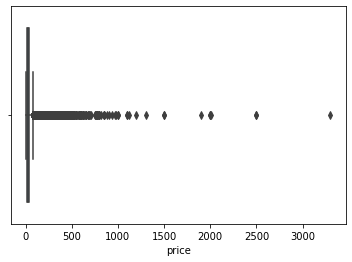

In [7]:
sns.boxplot(x=wine_rev.price)

A coluna price possui muitos outliers, porém, ela não será um fator determinante no sistema de recomendação. Também não sabemos se são outliers naturais ou não. Por hora, a coluna será mantida já que preço poderá ser utilizado posteriormente e, caso seja utilizado, estes problemas serão tratados.

Maiores avaliadores e paises avaliados:

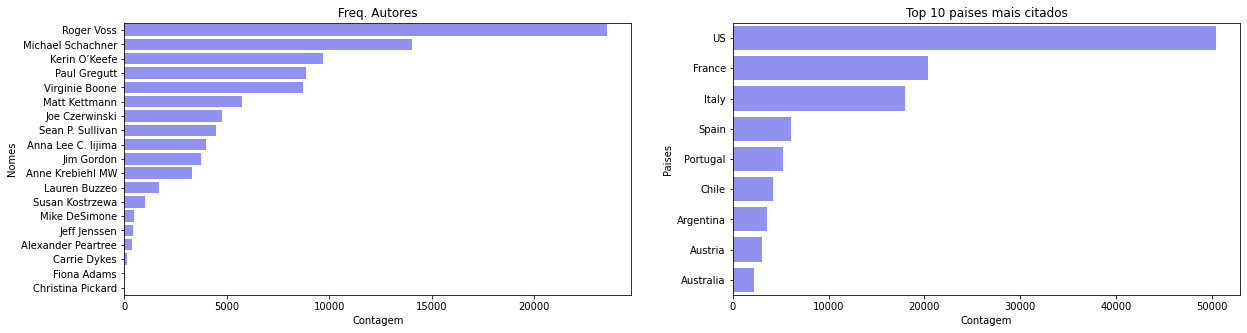

In [8]:
plt.subplots(1,2,figsize=(20,5))

plt.subplot(1,2,1)
sns.barplot(x=wine_rev.taster_name.value_counts(), y=wine_rev.taster_name.value_counts().index, color='#8181ff')
plt.ylabel('Nomes')
plt.xlabel('Contagem')
plt.title('Freq. Autores')

plt.subplot(1,2,2)
sns.barplot(x=wine_rev.country.value_counts()[0:9], y=wine_rev.country.value_counts().index[0:9], color='#8181ff')
plt.ylabel('Paises')
plt.xlabel('Contagem')
plt.title('Top 10 paises mais citados')

plt.show()

In [9]:
print(wine_rev.groupby('taster_name').agg('mean').query('taster_name in ["Roger Voss", "Michael Schachner", "Virginie Boone", "Paul Gregutt"]'), "\n\n")
print(wine_rev.groupby('country').agg('mean').query('country in ["US", "France", "Italy", "Spain"]'))

                      points      price
taster_name                            
Michael Schachner  86.857112  25.260183
Paul Gregutt       89.094159  33.705024
Roger Voss         88.733107  39.433101
Virginie Boone     89.220946  46.882170 


            points      price
country                      
France   88.866752  41.994105
Italy    88.576198  39.928286
Spain    87.235612  28.205654
US       88.555384  36.697520


Região com vinhos melhores avaliados, caros e baratos:

In [10]:
wine_rev.groupby('province').agg('mean').sort_values('points', ascending=False)['points']

province
Südburgenland                94.000000
Madeira                      93.230769
Mittelrhein                  92.000000
England                      91.746032
Wachau                       91.744681
                               ...    
Kentucky                     83.000000
Ticino                       83.000000
Middle and South Dalmatia    82.000000
Serra do Sudeste             82.000000
Table wine                   81.000000
Name: points, Length: 425, dtype: float64

In [11]:
wine_rev.groupby('province').agg('mean').sort_values('price', ascending=False)['price']

province
Colares              262.500000
Vânju Mare           166.000000
Switzerland          160.000000
Madeira              115.181818
Moscatel do Douro     94.750000
                        ...    
Tarnave                8.000000
Viile Timisului        7.500000
Ceres Plateau               NaN
Egypt                       NaN
Piekenierskloof             NaN
Name: price, Length: 425, dtype: float64

In [12]:
wine_rev.groupby('province').agg('mean').sort_values('price')['price']

province
Viile Timisului      7.5
Table wine           8.0
Cahul                8.0
Central Greece       8.0
Tarnave              8.0
                   ...  
Vânju Mare         166.0
Colares            262.5
Ceres Plateau        NaN
Egypt                NaN
Piekenierskloof      NaN
Name: price, Length: 425, dtype: float64

Palavras mais frequentes na descrição de vinhos:

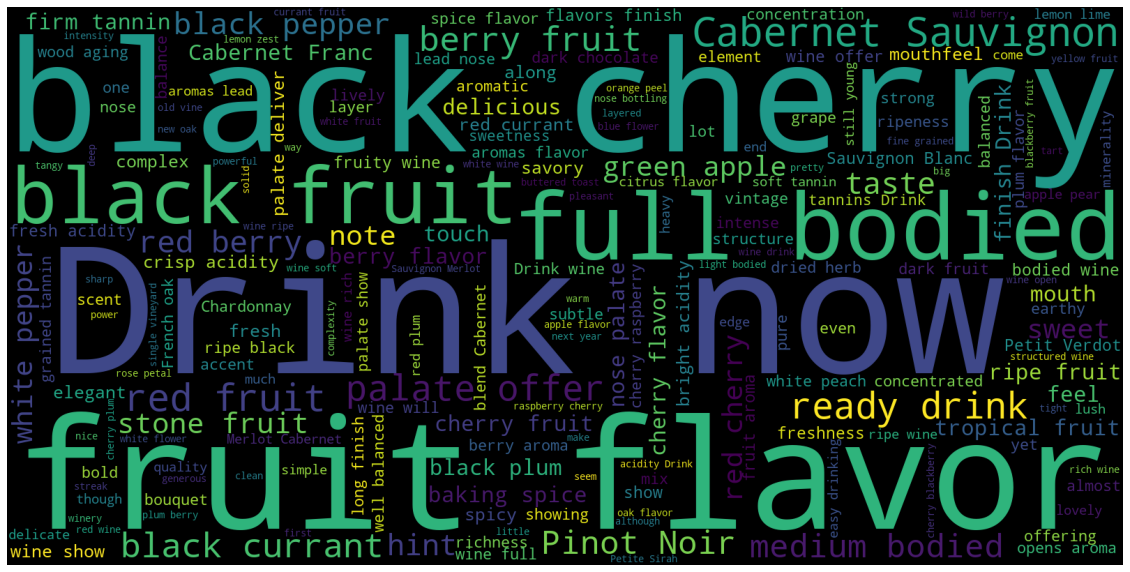

In [13]:
from wordcloud import WordCloud, STOPWORDS

# concatenar as palavras
all_summary = " ".join(s for s in wine_rev.description)
# lista de stopwords
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(all_summary)

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

Vinícola mais bem avaliada:

In [14]:
wine_rev.groupby('winery').agg('mean').sort_values('points', ascending=False)['points']

winery
Araujo                   98.000000
Ovid                     97.000000
J.L. Chave               97.000000
Gandona                  97.000000
Tenuta dell'Ornellaia    96.888889
                           ...    
Ronan                    80.000000
Baroncini                80.000000
Buzzard Tree             80.000000
Eleusis                  80.000000
Bodegas del Mundo        80.000000
Name: points, Length: 16757, dtype: float64

## (3 pontos) Sistema de recomendação: 


Faça a construção de seu sistema de recomendação

O primeiro passo é identificar qual cometário trata de qual vinho. Vinhos possuem muitas formas de identificação, a mais comum é uma combinação entre o tipo de uva, o produtor e o ano do vinho. Muitos vinhos também contam com informações como marcas, tipo do vinho, temperatura, teor alcoolico e etc, porém, os dados que são constantes são apenas os citados anteriormente. Todas as informações relevantes estão contidas na coluna 'title'.

In [15]:
wine_rev = wine_rev[['description', 'title', 'points',	'price']] # Somente 'description' e 'title' são relevantes para o sistema de recomendação, 'price' e 'points' são informações relevantes para o usuário.

In [16]:
wine_rev['title'].value_counts() # Há diferenças no numero de avaliações entre os vinhos

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                         9
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                        7
Segura Viudas NV Extra Dry Sparkling (Cava)                                    7
Bailly-Lapierre NV Brut  (Crémant de Bourgogne)                                6
J Vineyards & Winery NV Brut Rosé Sparkling (Russian River Valley)             6
                                                                              ..
Stroblhof 2012 Pigeno Pinot Nero (Alto Adige)                                  1
St. Pauls 2013 Passion Vernatsch Schiava (Alto Adige)                          1
Scott Family 2013 Dijon Clone Pinot Noir (Arroyo Seco)                         1
Ram's Gate 2012 Bush Crispo Vineyard Pinot Noir (Russian River Valley)         1
Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)    1
Name: title, Length: 118840, dtype: int64

In [17]:
wine_rev['title'] = wine_rev['title'].apply(lambda x: x.strip()) # Retirada dos espaços antes e após os titulos

Temos 118840 tipos distintos de vinhos, cada vinho possui diferentes quantidades de descrições. Os passos para a preparação dos dados serão os seguintes:
- Unificação dos textos: descrições pertencentes a um mesmo vinho serão unificadas.
- Exclusão de stop words: stops words não acrescentam nada a um modelo de machine learning, stop words não possuem função semântica.
- Normalização: Todos os textos serão normalizados para letras minusculas.
- Tokenization: os textos serão dividos em tokens.
- Lemmatization: os tokens serão reduzidas aos seus lemas para que o ruído do texto seja diminuído mantendo somente a função semântica das palavras.

In [18]:
description_final = []
wine_list = wine_rev['title'].unique() # lista de vinhos únicos

for i in range(0,len(wine_list)): # Laço de repetição que junta as descrições de um mesmo vinho em um único elemento e ordena numa lista
  description_final.append(wine_rev[wine_rev['title'] == wine_list[i]]['description'].tolist())
  description_final[i] = ' '.join(j for j in description_final[i])

In [19]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nlp = spacy.load('en_core_web_lg')
description_final = [nlp(i) for i in description_final] # Aplica o modelo de NLP na descrição

for i in range(len(description_final)): # Laço de repetição extrai o lema e retira as stop words e pontuações
  description_final[i] = ' '.join(j.lemma_.lower() for j in description_final[i] if ((not j.is_stop) & (not j.is_punct)))

vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2)) # Vetorização com contagem de palavras
tfidf_transformer = TfidfTransformer()

description_final = vectorizer.fit_transform(description_final)
description_final = tfidf_transformer.fit_transform(description_final) # Transformação da contagem de palavras para tfidf
description_final.shape

(118840, 697766)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Retorna
def recomendacao(user_wine, n_recomendations):
  if user_wine in wine_list:
    user_input = np.where(wine_list == user_wine) # Encontra o vinho do usuário na lista de vinhos
    user_input = description_final[user_input[0][0]] # Encontra a descrição para o vinho do usuário

    cos_similarity = cosine_similarity(user_input, description_final) # Similaridade entre a descrição do vinho do usuário e os outros vinhos
    return wine_list[cos_similarity[0].argsort()[::-1][1:n_recomendations+1]] # O indice 0 sempre será o próprio vinho escolhido pelo usuário

  else:
    return 'Este vinho não foi foi encontrado na base de dados!' # Retorna essa mensagem caso o vinho não seja encontrado

In [21]:
random_idx = np.random.randint(0, len(wine_list)) # Seleção de vinho aleatória para testes
print(f'Vinho escolhido: {wine_list[random_idx]}')

wine_recom = recomendacao(wine_list[random_idx], 10)
wine_recom

Vinho escolhido: Château Mayne Vieil 2013  Fronsac


array(['Georges Duboeuf 2011 Domaine de Lafayette  (Brouilly)',
       'Barão de Vilar 2011 Palmer  (Port)',
       "Château de l'Orangerie 2007 Grand Classique  (Premieres Côtes de Bordeaux)",
       'Domaine de la Pepière 2012 Clisson  (Muscadet Sèvre et Maine Clisson)',
       "Domaine Baron de l'Ecluse 2015 Vieilles Vignes  (Côte de Brouilly)",
       'Wines & Winemakers 2012 Andreza Reserva Red (Douro)',
       'Château La Rose Poncet 2011 Mon Ange  (Castillon Côtes de Bordeaux)',
       'Château Camelot la Chapelle 2011  Bordeaux',
       'Quinta do Casal Branco 2009 Muge Vingas Velhas Red (Tejo)',
       'Château Pilet 2015 Cuvée Prestige  (Côtes de Bordeaux)'],
      dtype=object)

Os vinhos recomendados são:

In [22]:
wine_rev[wine_rev['title'].isin(wine_recom)]

,description,title,points,price
23049,"A wine with some structure, firm tannins and a...",Georges Duboeuf 2011 Domaine de Lafayette (Br...,88,NaN
28059,This is a wine with potential. It has weight a...,Château Camelot la Chapelle 2011 Bordeaux,90,10.0
29330,Mint and eucalyptus aromas set the scene for a...,Quinta do Casal Branco 2009 Muge Vingas Velhas...,92,NaN
34670,"Made for aging, this wine is structured and fi...",Domaine de la Pepière 2012 Clisson (Muscadet ...,93,25.0
52501,This wine combines freshness and structure. It...,Wines & Winemakers 2012 Andreza Reserva Red (D...,88,18.0
72883,This is an ageworthy wine from 60-year-old vin...,Domaine Baron de l'Ecluse 2015 Vieilles Vignes...,91,25.0
72904,Fine tannins and attractive acidity set the sc...,Barão de Vilar 2011 Palmer (Port),91,NaN
81924,Dusty tannins and ripe fruit set the scene for...,Château Pilet 2015 Cuvée Prestige (Côtes de B...,92,25.0
99768,"While big, ripe and jammy, this wine has firm ...",Château La Rose Poncet 2011 Mon Ange (Castill...,88,NaN
104161,Tobacco aromas and tight tannins set the scene...,Château de l'Orangerie 2007 Grand Classique (...,83,NaN


## (4 pontos) Relatório: 
Construa um relatório utilizando o Markdown para escrever. Seja criativo para apresentar seus achados e siga os passos abaixo:  
- Imagine que você possui uma startup e este é o primeiro relatório apresentará
- Coloque o nome do seu produto  
- Apresente a introdução do problema (seja sucinto, escreva com poucas palavras)
- Coloque gráficos e frases para sustentar seus argumentos
- Mostre as soluções do mercado
- Escreva sobre a sua solução e por que ela é a melhor



---


### *Reserve*: um aplicativo de recomendações de vinhos


Um dos aspectos que mais impressiona quem gosta de vinho é a sua infinita variedade. É comum tentar escolher uma garrafa e se perder em meio a tantas opções.

Sabemos o trabalho que é aprender a identificar as infinitas possibilidades que o mundo dos vinhos oferece, são tantos nomes, marcas, safras, tipos, variedades que parece impossivel aprender, mesmo que o básico. Isso nos leva ao principal problema do mundo dos vinhos, muitos apreciadoras compram garrafas sem realmente entender o que estão comprando, e muito melhor do que apreciar um bom vinho é apreciar com sabedoria.

Nosso aplicativo '*Reserve*' existe exatamente para acabar de uma vez por todas com a indecisão na hora de comprar uma garrafa.


---

### Cenário atual

Hoje, os apreciadores de vinho costumam se dispor em comunidades, você geralmente compra uma garrafa recomendada por um amigo que comprou por recomendação de outro amigo que comprou por recomendação de outro amigo... Só que o mundo é muito maior do que o seu circulo social!

Só na WineMag, revista digital do catalogo Wine Enthusiast, podemos encontrar mais de 110000 tipos de vinho com notas acima de 80, é dificil acreditar que você esteja fazendo a melhor escolha para a sua ocasião baseado apenas em opiniões de amigos.

In [23]:
len(wine_rev['title'].unique())

118840

Segundo o site statisa.com, o número de vinícolas nos EUA chegou em mais de 11.000 em 2021. Desde 2009, o número de vinícolas do país cresceu mais de 50%. O número de marcas de vinhos, cada um com suas especificações, certamente é ainda maior.

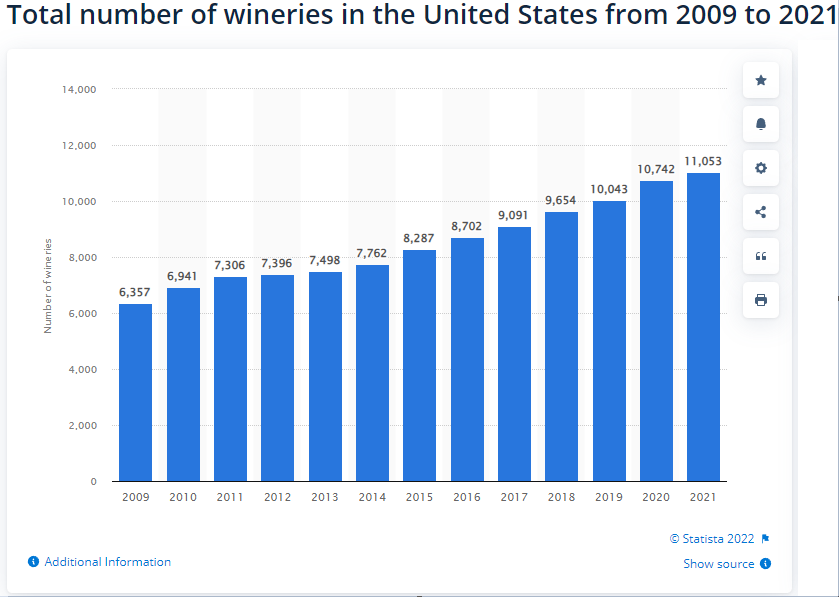   
Disponível em: https://www.statista.com/statistics/259353/number-of-wineries-in-the-us/


Além disso, sabemos que estes números retratam o cenário apenas nos EUA, quando levamos em conta a produção em todo o mundo, esse número pode ser ainda maior. Observando as analises da WineMag encontramos uma diversidade assustadora, são muitas marcas, de muitos paises.

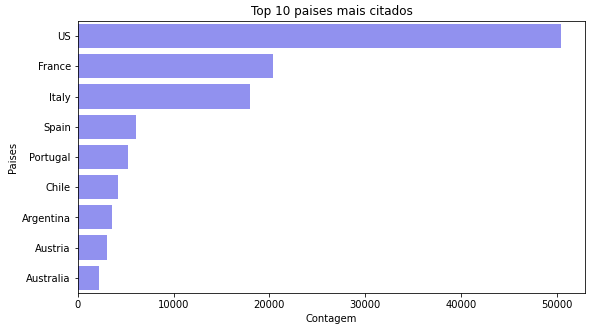


Em meio a tanta variedade de vinhos, o consumo segue sendo impressionante, segundo o site wineinstitute.org, em 2021, só nos Estados Unidos, foram consumidos cerca de 1,1 bilhão de galões de vinho. Um consumo crescente em um cenário complicado de se inserir.  
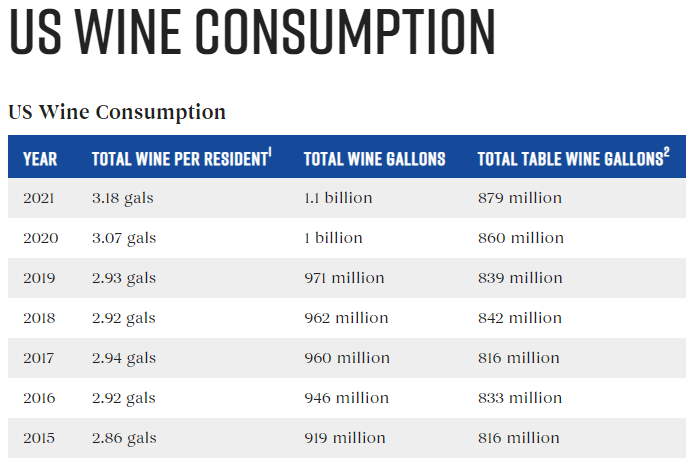  
Disponível em: https://wineinstitute.org/our-industry/statistics/us-wine-consumption/

Para atender a este mercado crescente e com uma diversidade tão rica, o *Reserve* tem como a função de trazer sabedoria para sua escolha de garrafas de vinho. Hoje, já existem alguns aplicativos que auxiliam na escolha mas nenhum deles se atenta as opiniões de profissionais como o *Reserve* se atenta.  
- My Wine Society: É uma rede social para apreciadores de vinho, a ideia do My Wine Society é unir as pessoas e compartilhar suas experiências, dicas e dúvidas sobre o mundo dos vinhos.
- Vivino: Um dos catalogos de vinho mais completos do mercado, para utilizar o Vivino, tudo o que você precisa é um rótulo e então você tem acesso a notas, preços e combinações de comida.
- Wine Ring: A solução do mercado mais semelhante ao *Reserve*, o aplicativo permite o usuário avaliar e compartilhar sua experiência com vinhos, tendo recomendações baseadas em suas avaliações.


---

### Porque o *Reserve* é o melhor

Nós da *Reserve* contamos com a parceria inédita da revista digital Wine Ethusiast que possui mais de 800000 leitores e é publicada 14 vezes ao ano com um total de 24000 avaliações anuais feitas por profissionais. Ao contrário dos nossos concorrentes, que utilizam as reviews e inputs de todos os usuários, o *Reserve* utiliza exclusivamente as opiniões profissionais para se realizar uma recomendação. Ao utilizar nosso aplicativo, você sabe que sua escolha leva uma bagagem imensurável de sabedoria.  

É possível dizer que o *Reserve* é um aplicativo para quem realmente quer aprender sobre vinhos, nós vamos muito além de uma simples opinião, nós trazemos todo o conhecimento de diversos profissionais para que, além de ter uma boa garrafa, você se aprofunde nesse mundo extremamente rico e bonito dos vinhos.